### Packages

In [1]:
using DynamicalSystems, DifferentialEquations, OrdinaryDiffEq, StaticArrays
using CairoMakie

### Parametres

In [2]:
τ = 0.013; τ_D = 0.15; τ_y = 1.8; τ_F = 1;
α = 1.5; J = 3.07; β = 0.4375
U0 = 0.35; ΔU0 = 0.305
xthr = 0.9; ythr = 0.5
I0 = -1.7;

### function system

In [3]:
U(y) = U0 + ΔU0 / ( 1 + exp( -50 * ( y - ythr ) ) )
σ(x)= 1 / (1 + exp(-20 * (x - xthr)));

In [4]:
function model(u, p ,t)
    E, x, u_, y = u
    τ, α, τ_D, J, U0, ΔU0, τ_y, β, xthr, ythr, I0 = p
    du1 = (-E + α * log( 1 + exp( ( J * u_ * x * E + I0 ) / α ) )) / τ
    du2 = ( 1 - x ) / τ_D - u_ * x * E
    du3 = (U(y) - u_) / τ_F + U(y) * ( 1 - u_ ) * E
    du4 = -y /  τ_y + β * σ(x)
    return SVector(du1, du2, du3, du4)
end;

### initialize system

u0 = SA[3.3403239669724387, 0.1, 0.1, 0.03677942307955071] # INITAL CONDITION DON'T TOUCH

In [5]:
p = SA[τ, α, τ_D, J, U0, ΔU0, τ_y, β, xthr, ythr, I0]
u0 = SA[7.3403239669724387, 1.7, 0.4, 0.43677942307955071]  # INITAL CONDITION DON'T TOUCH
tspan = (0.0, 500.0);
ds = ContinuousDynamicalSystem(model, u0, p)

4-dimensional continuous dynamical system
 state:       [7.34032, 1.7, 0.4, 0.436779]
 rule f:      model
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [0.013, 1.5, 0.15, 3.07, 0.35, …, 1.8, 0.4375, 0.9, 0.5, -1.7]

### Trajectory

In [6]:
tr = trajectory(ds, tspan[2], Ttr = tspan[2]; Δt = 0.001, diffeq = (alg = RK4(),  adaptive = false, dense = false, dt = 0.001))

4-dimensional Dataset{Float64} with 500001 points
 5.09636  0.395339  0.853034  0.0160101
 4.99084  0.397657  0.85279   0.0160012
 4.88776  0.399985  0.852542  0.0159923
 4.78706  0.402324  0.85229   0.0159835
 4.68867  0.404671  0.852033  0.0159746
 4.59253  0.407028  0.851771  0.0159658
 4.4986   0.409393  0.851506  0.0159569
 4.40683  0.411766  0.851236  0.0159481
 4.31715  0.414147  0.850962  0.0159393
 4.22952  0.416534  0.850684  0.0159304
 4.1439   0.418929  0.850403  0.0159216
 4.06024  0.421329  0.850118  0.0159128
 3.97849  0.423736  0.849829  0.015904
 ⋮                            
 1.14211  0.648344  0.812282  0.0151036
 1.1401   0.650081  0.811895  0.0150981
 1.13828  0.651807  0.811508  0.0150927
 1.13664  0.65352   0.811122  0.0150874
 1.13517  0.655221  0.810736  0.0150822
 1.13388  0.656911  0.810351  0.0150772
 1.13276  0.658589  0.809966  0.0150722
 1.1318   0.660255  0.809582  0.0150674
 1.13101  0.661909  0.809198  0.0150626
 1.13037  0.663551  0.808814  0.015058
 

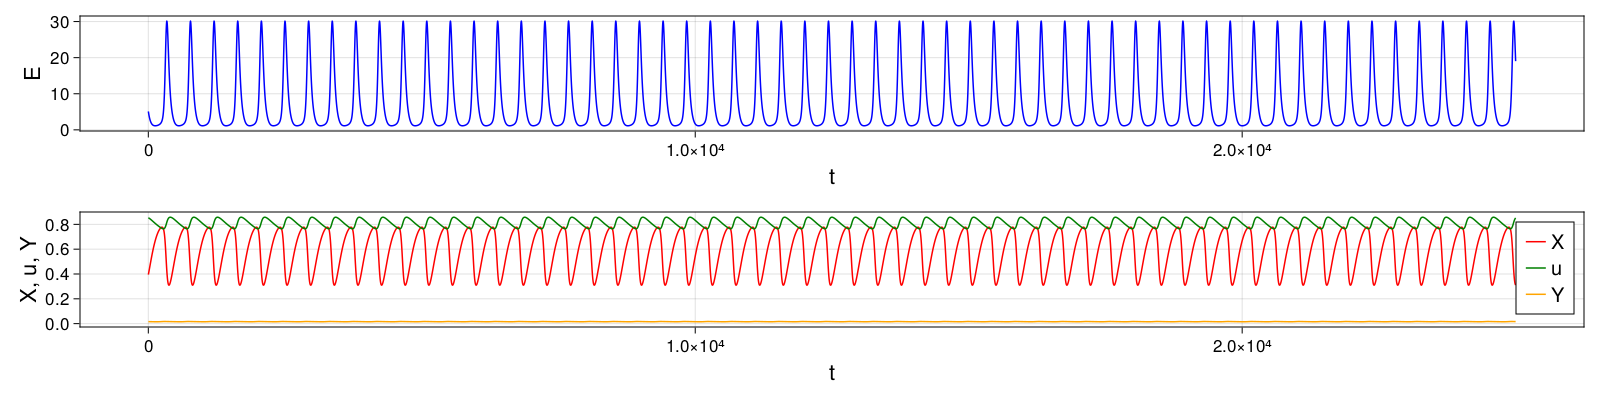

In [7]:
ts, tf = 1, 25000

f = Figure(resolution = (1600, 400))
ax1 = Axis(f[1, 1], xlabel = "t", ylabel = "E", xlabelsize = 22, ylabelsize = 22,xticklabelsize = 17, yticklabelsize = 17)
ax2 = Axis(f[2, 1], xlabel = "t", ylabel = "X, u, Y", xlabelsize = 22, ylabelsize = 22,xticklabelsize = 17, yticklabelsize = 17)

lines!(ax1, tr[ts:tf, 1], color = "blue", label = "E")
lines!(ax2, tr[ts:tf, 2], color = "red", label = "X")
lines!(ax2, tr[ts:tf, 3], color = "green", label = "u")
lines!(ax2, tr[ts:tf, 4], color = "orange", label = "Y")


"""
ax1.xgridvisible = false
ax1.ygridvisible = false
ax2.xgridvisible = false
ax2.ygridvisible = false"""

axislegend(ax2, labelsize=20)
f

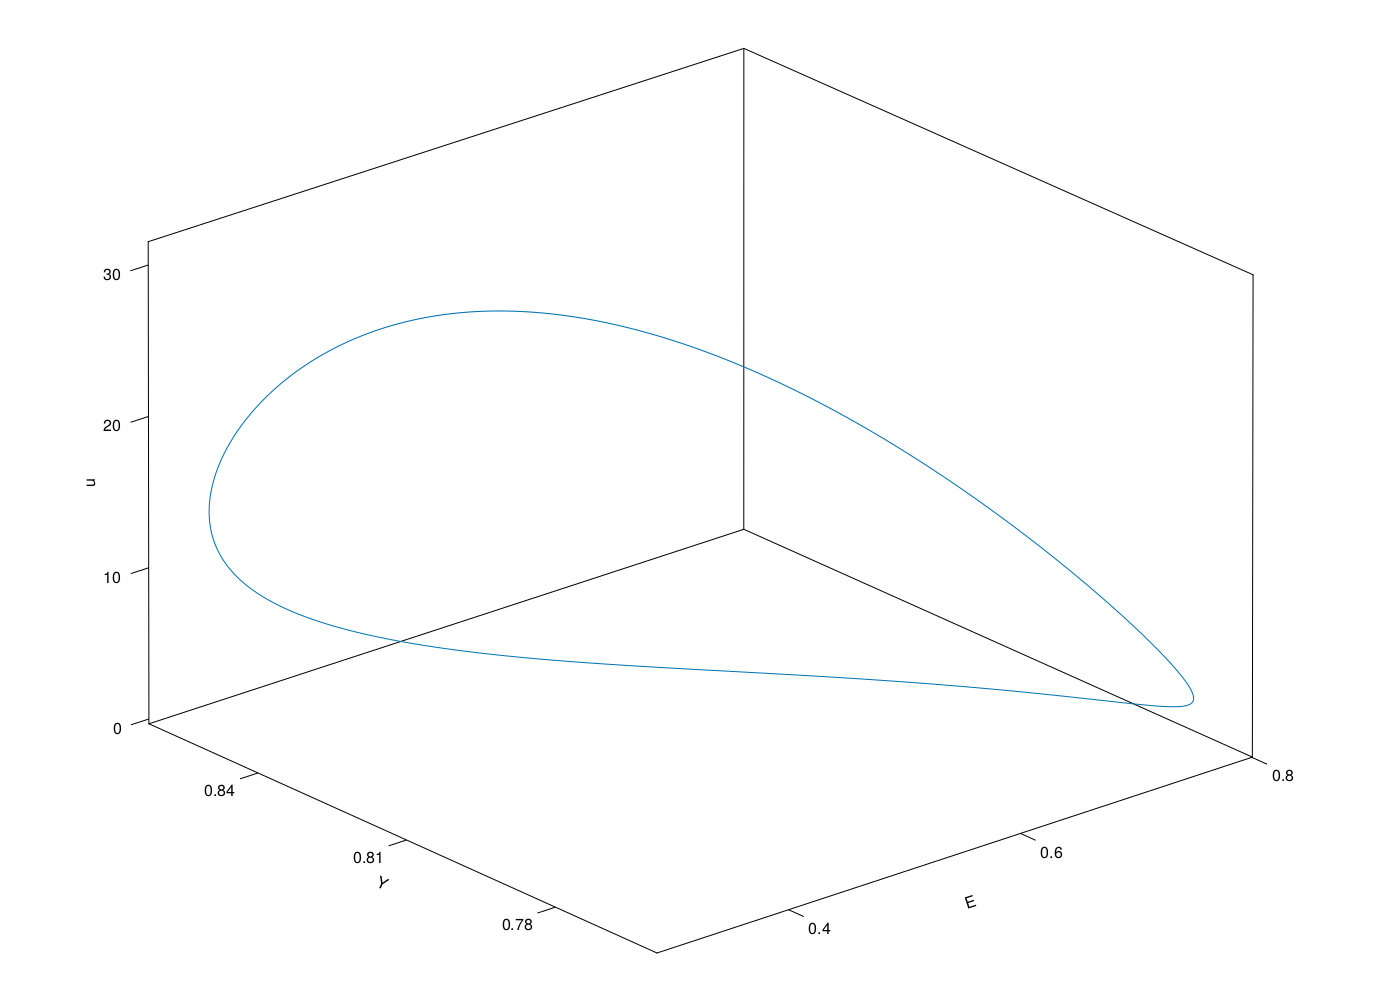

In [8]:
cord1 = 2
cord2 = 3
cord3 = 1
ts, tf = 1, 25000

f = Figure(resolution = (1400, 1000))
ax = Axis3(f[1, 1], xlabel = "E", ylabel = "Y", zlabel = "u")
ax.xgridvisible = false
ax.ygridvisible = false
ax.zgridvisible = false
lines!(tr[ts:tf, cord1], tr[ts:tf, cord2], tr[ts:tf, cord3], linewidth = 1)
f

In [9]:
λλ = lyapunovspectrum(ds, tspan[2], Δt = 1, Ttr = tspan[2]/2; diffeq = (alg = RK4(),  adaptive = false, dt = 0.001) )

4-element Vector{Float64}:
  0.0071984107887812995
 -0.5555555534387822
 -2.8525262528861957
 -5.866895765412158

### function for 2d map

In [10]:
function check_fp_point(fp, point)
"""
    Проверка на совпадение точки с одним из состояний равновесия.
    
    Алгоритм
        - Находится кол-во состояний равновесия, задаётся некоторое ϵ.
        - Проходимся по всем состояниям равновесия и сравниваем их с точкой с помощью следующего неравенства:
            abs( (E_fp, X_fp, u_fp, Y_fp) - abs( (E_p, X_p, u_p, Y_p) ) ) < ϵ
            то есть, если расстояние между двумя точками по модулю строго меньше, чем ϵ
        - Если неравенство выполняется, то сохраняем индекс, который соответствует этому состоянию равновесия
        - Иначе сохраняем индекс -1
        - По выполнению цикла ищем максимум из всех индексов.
"""
    
    len = length(fp)
    ϵ = [0.001, 0.001, 0.001, 0.001]
    res = zeros(len)
    
    for index in range(1, len, step = 1)
    
        if ( abs.(fp[index] - abs.(point)) ) < ϵ
            res[index] = index
        else
            res[index] = -1

        end
        
    end
    return convert(Int64, maximum(res))
end

function check_eigs_SLE(λλ, eigs)
"""
    Проверка на совпадение SLE (Спектр Ляпуновских показателей) и собственных чисел состояния равновесия
    
    Алгоритм
        - Задаётся ϵ вектор.
        - Если разница между собственными числами состояния равновесия и SLE меньше заданного ϵ вектора, то вернуть true
        - иначе вернуть false
"""
    ϵ = [0.01, 0.01, 0.01, 0.01]
    dif = abs.( sort( real(eigs) ) + (-1) * sort( λλ ) )
    
    if dif < ϵ
        return true # bad
    else
        return false # good
    end
end

function check_start(u0_started = SA[3.3403239669724387, 0.1, 0.1, 0.03677942307955071])

    if flag_start == true
                global u0_loc = u0_started
                flag_start == false
    end
    
end
function output(index_i, index_j, U0_lc, I0_lc, u0_lc)
        println("index i: $index_i"); flush(stdout)
        println("index j: $index_j"); flush(stdout)
        println("U0: $U0_lc;"); flush(stdout)
        println("I0: $I0_lc;"); flush(stdout)
        println("u0: $u0_lc;"); flush(stdout)
end
function separate()
    println(" --------------------- "); flush(stdout)
    println("  "); flush(stdout)
end

separate (generic function with 1 method)

### 2d map

In [33]:
I0_start =  -1.8
I0_finish = -1.45
I0_step = 0.01

U0_start =  0.35
U0_finish = 0.32
U0_step = -0.001

range_U0 = range(U0_start, U0_finish, step = U0_step)
range_I0 = range(I0_start, I0_finish, step = I0_step)

array_u0 = zeros(length(range_U0), length(range_I0), 4 )
array_SLE = zeros(length(range_U0), length(range_I0), 4 );

In [34]:
length(range_U0), length(range_I0)

(31, 36)

In [ ]:
SA[7.3403239669724387, 1.7, 0.4, 0.43677942307955071]
SA[3.3403239669724387, 0.1, 0.1, 0.03677942307955071] # НАЧАЛЬНЫЕ УСЛОВИЯ ДЛЯ 0.35;-1.8 НЕ ТРОГАТЬ

In [ ]:
for (index_i, U0_lc) in enumerate(range_U0)
    for (index_j, I0_lc) in enumerate(range_I0)
        
        if index_j == 1
            println(" LEFT END ")
            global u0_lc = SA[7.3403239669724387, 1.7, 0.4, 0.43677942307955071]
        end

        output(index_i, index_j, U0_lc, I0_lc, u0_lc)
        
        p_loc = SA[τ, α, τ_D, J, U0_lc, ΔU0, τ_y, β, xthr, ythr, I0_lc]
        ds_loc = ContinuousDynamicalSystem(model, u0_lc, p_loc)

        tr_loc = trajectory(ds_loc, tspan[2], Ttr = tspan[2]; Δt = 0.001, diffeq = (alg = RK4(),  adaptive = false, dense = false, dt = 0.001))
        u0_lc = tr_loc[end, :]
        
        array_u0[index_i, index_j, :] = u0_lc
        
        random_dot = tr_loc[300000, :]
        println("random point: $random_dot")
        
        λλ = lyapunovspectrum(ds_loc, tspan[2], Δt = 1, Ttr = tspan[2]/2; diffeq = (alg = RK4(),  adaptive = false, dt = 0.001) )
        println("λλ: $λλ;")
        array_SLE[index_i, index_j, :] = λλ
        separate()
    end
end

 LEFT END 
index i: 1
index j: 1
U0: 0.35;
I0: -1.8;
u0: [7.340323966972439, 1.7, 0.4, 0.4367794230795507];
random point: [0.8915345060748258, 0.6890691772141517, 0.7978452140374473, 0.03615290896391499]
λλ: [-0.009521424980910121, -0.5555555581766042, -2.2776747545256657, -8.778429123592735];
 --------------------- 
  
index i: 1
index j: 2
U0: 0.35;
I0: -1.79;
u0: [1.2833769978405178, 0.554458121940517, 0.8246099694305704, 0.03736872418785878];
random point: [17.376068793257197, 0.6714893654233705, 0.7571339035953265, 0.03797831736765537]
λλ: [0.003373950499677777, -0.5555555535858893, -2.355411917427978, -8.549446147112961];
 --------------------- 
  
index i: 1
index j: 3
U0: 0.35;
I0: -1.78;
u0: [14.533459208187107, 0.3136662018993211, 0.8486410467673151, 0.03640230551767479];
random point: [0.9399028595484646, 0.7035904915384146, 0.7954345767684504, 0.030337306746797566]
λλ: [0.004798205429828146, -0.5555555546346718, -2.4280155604970117, -8.304235308238775];
 -------------------

  
index i: 1
index j: 25
U0: 0.35;
I0: -1.56;
u0: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5];
random point: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5]
λλ: [-0.5555555555685866, -1.6527797552728751, -1.6511642032683316, -4.232045071627315];
 --------------------- 
  
index i: 1
index j: 26
U0: 0.35;
I0: -1.55;
u0: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5];
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.7193666266871028, -1.709931130385955, -4.242217273166863];
 --------------------- 
  
index i: 1
index j: 27
U0: 0.35;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5];
random point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
λλ: [-0.5555555555685862, -1.7788109279897926, -1.775209691173772, -4.2523326825781975]

  
index i: 2
index j: 13
U0: 0.349;
I0: -1.68;
u0: [1.6399933307744414, 0.7596898723715607, 0.7794028211489672, 0.014076797250032662];
random point: [8.47850969751541, 0.7263455191387882, 0.7704960551194386, 0.013950963189002515]
λλ: [-0.004289032692902713, -0.5555555564522694, -2.9179233237184365, -5.086248445844308];
 --------------------- 
  
index i: 2
index j: 14
U0: 0.349;
I0: -1.67;
u0: [1.525943093549827, 0.7455342468285053, 0.7852894067112168, 0.012499072152641386];
random point: [1.5922528285339972, 0.7417745700474818, 0.7865878878640563, 0.011191312511342455]
λλ: [-0.005716536893262502, -0.5555555562894032, -2.936291877093347, -4.669898648550851];
 --------------------- 
  
index i: 2
index j: 15
U0: 0.349;
I0: -1.66;
u0: [1.6184761192415889, 0.7434697465620396, 0.7858995176246384, 0.011217000383013234];
random point: [7.902996993764078, 0.7220567107570339, 0.7750057230377313, 0.010975313053501579]
λλ: [-0.0013606204086568114, -0.5555555556288019, -2.93008346911211, -4.2362

  
 LEFT END 
index i: 3
index j: 1
U0: 0.348;
I0: -1.8;
u0: [7.340323966972439, 1.7, 0.4, 0.4367794230795507];
random point: [0.8915345060748258, 0.6890691772141517, 0.7978452140374473, 0.03615290896391499]
λλ: [-0.009521424980910121, -0.5555555581766042, -2.2776747545256657, -8.778429123592735];
 --------------------- 
  
index i: 3
index j: 2
U0: 0.348;
I0: -1.79;
u0: [1.2833769978405178, 0.554458121940517, 0.8246099694305704, 0.03736872418785878];
random point: [17.376068793257197, 0.6714893654233705, 0.7571339035953265, 0.03797831736765537]
λλ: [0.003373950499677777, -0.5555555535858893, -2.355411917427978, -8.549446147112961];
 --------------------- 
  
index i: 3
index j: 3
U0: 0.348;
I0: -1.78;
u0: [14.533459208187107, 0.3136662018993211, 0.8486410467673151, 0.03640230551767479];
random point: [0.9399028595484646, 0.7035904915384146, 0.7954345767684504, 0.030337306746797566]
λλ: [0.004798205429828146, -0.5555555546346718, -2.4280155604970117, -8.304235308238775];
 -------------

  
index i: 3
index j: 25
U0: 0.348;
I0: -1.56;
u0: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5];
random point: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5]
λλ: [-0.5555555555685866, -1.6527507759440925, -1.6511931825971147, -4.232045071627315];
 --------------------- 
  
index i: 3
index j: 26
U0: 0.348;
I0: -1.55;
u0: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5];
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.719624614331326, -1.7096731427417287, -4.242217273166863];
 --------------------- 
  
index i: 3
index j: 27
U0: 0.348;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5];
random point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
λλ: [-0.5555555555685862, -1.7786005686978832, -1.775420050465682, -4.25233268257819

  
index i: 4
index j: 13
U0: 0.347;
I0: -1.68;
u0: [1.6399933307744414, 0.7596898723715607, 0.7794028211489672, 0.014076797250032662];
random point: [8.47850969751541, 0.7263455191387882, 0.7704960551194386, 0.013950963189002515]
λλ: [-0.004289032692902713, -0.5555555564522694, -2.9179233237184365, -5.086248445844308];
 --------------------- 
  
index i: 4
index j: 14
U0: 0.347;
I0: -1.67;
u0: [1.525943093549827, 0.7455342468285053, 0.7852894067112168, 0.012499072152641386];
random point: [1.5922528285339972, 0.7417745700474818, 0.7865878878640563, 0.011191312511342455]
λλ: [-0.005716536893262502, -0.5555555562894032, -2.936291877093347, -4.669898648550851];
 --------------------- 
  
index i: 4
index j: 15
U0: 0.347;
I0: -1.66;
u0: [1.6184761192415889, 0.7434697465620396, 0.7858995176246384, 0.011217000383013234];
random point: [7.902996993764078, 0.7220567107570339, 0.7750057230377313, 0.010975313053501579]
λλ: [-0.0013606204086568114, -0.5555555556288019, -2.93008346911211, -4.2362

  
 LEFT END 
index i: 5
index j: 1
U0: 0.346;
I0: -1.8;
u0: [7.340323966972439, 1.7, 0.4, 0.4367794230795507];
random point: [0.8915345060748258, 0.6890691772141517, 0.7978452140374473, 0.03615290896391499]
λλ: [-0.009521424980910121, -0.5555555581766042, -2.2776747545256657, -8.778429123592735];
 --------------------- 
  
index i: 5
index j: 2
U0: 0.346;
I0: -1.79;
u0: [1.2833769978405178, 0.554458121940517, 0.8246099694305704, 0.03736872418785878];
random point: [17.376068793257197, 0.6714893654233705, 0.7571339035953265, 0.03797831736765537]
λλ: [0.003373950499677777, -0.5555555535858893, -2.355411917427978, -8.549446147112961];
 --------------------- 
  
index i: 5
index j: 3
U0: 0.346;
I0: -1.78;
u0: [14.533459208187107, 0.3136662018993211, 0.8486410467673151, 0.03640230551767479];
random point: [0.9399028595484646, 0.7035904915384146, 0.7954345767684504, 0.030337306746797566]
λλ: [0.004798205429828146, -0.5555555546346718, -2.4280155604970117, -8.304235308238775];
 -------------

  
index i: 5
index j: 25
U0: 0.346;
I0: -1.56;
u0: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5];
random point: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5]
λλ: [-0.5555555555685866, -1.652664589571406, -1.6512793689697998, -4.232045071627318];
 --------------------- 
  
index i: 5
index j: 26
U0: 0.346;
I0: -1.55;
u0: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5];
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.7211715942119723, -1.7081261628610875, -4.242217273166863];
 --------------------- 
  
index i: 5
index j: 27
U0: 0.346;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5];
random point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
λλ: [-0.5555555555685862, -1.7781874576909982, -1.7758331614725706, -4.2523326825781

  
index i: 6
index j: 13
U0: 0.345;
I0: -1.68;
u0: [1.6399933307744414, 0.7596898723715607, 0.7794028211489672, 0.014076797250032662];
random point: [8.47850969751541, 0.7263455191387882, 0.7704960551194386, 0.013950963189002515]
λλ: [-0.004289032692902713, -0.5555555564522694, -2.9179233237184365, -5.086248445844308];
 --------------------- 
  
index i: 6
index j: 14
U0: 0.345;
I0: -1.67;
u0: [1.525943093549827, 0.7455342468285053, 0.7852894067112168, 0.012499072152641386];
random point: [1.5922528285339972, 0.7417745700474818, 0.7865878878640563, 0.011191312511342455]
λλ: [-0.005716536893262502, -0.5555555562894032, -2.936291877093347, -4.669898648550851];
 --------------------- 
  
index i: 6
index j: 15
U0: 0.345;
I0: -1.66;
u0: [1.6184761192415889, 0.7434697465620396, 0.7858995176246384, 0.011217000383013234];
random point: [7.902996993764078, 0.7220567107570339, 0.7750057230377313, 0.010975313053501579]
λλ: [-0.0013606204086568114, -0.5555555556288019, -2.93008346911211, -4.2362

  
 LEFT END 
index i: 7
index j: 1
U0: 0.344;
I0: -1.8;
u0: [7.340323966972439, 1.7, 0.4, 0.4367794230795507];
random point: [0.8915345060748258, 0.6890691772141517, 0.7978452140374473, 0.03615290896391499]
λλ: [-0.009521424980910121, -0.5555555581766042, -2.2776747545256657, -8.778429123592735];
 --------------------- 
  
index i: 7
index j: 2
U0: 0.344;
I0: -1.79;
u0: [1.2833769978405178, 0.554458121940517, 0.8246099694305704, 0.03736872418785878];
random point: [17.376068793257197, 0.6714893654233705, 0.7571339035953265, 0.03797831736765537]
λλ: [0.003373950499677777, -0.5555555535858893, -2.355411917427978, -8.549446147112961];
 --------------------- 
  
index i: 7
index j: 3
U0: 0.344;
I0: -1.78;
u0: [14.533459208187107, 0.3136662018993211, 0.8486410467673151, 0.03640230551767479];
random point: [0.9399028595484646, 0.7035904915384146, 0.7954345767684504, 0.030337306746797566]
λλ: [0.004798205429828146, -0.5555555546346718, -2.4280155604970117, -8.304235308238775];
 -------------

  
index i: 7
index j: 25
U0: 0.344;
I0: -1.56;
u0: [9.847608842210509, 0.4422396936557301, 0.8538229710378552, 8.320495157120142e-5];
random point: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5]
λλ: [-0.5555555555685866, -1.6527307205606283, -1.651213237980578, -4.232045071627318];
 --------------------- 
  
index i: 7
index j: 26
U0: 0.344;
I0: -1.55;
u0: [9.871329980745195, 0.44156765756863614, 0.854095390643789, 8.209421482539893e-5];
random point: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5]
λλ: [-0.5555555555685864, -1.7188938487306318, -1.7104039083424263, -4.2422172731668635];
 --------------------- 
  
index i: 7
index j: 27
U0: 0.344;
I0: -1.54;
u0: [9.894957995870078, 0.4409002031902562, 0.8543657332607749, 8.100572602027987e-5];
random point: [9.918494336321942, 0.44023725894722376, 0.8546340328087, 7.993887769064508e-5]
λλ: [-0.5555555555685862, -1.778588338912546, -1.7754322802510214, -4.2523326825781

In [ ]:
fig, ax, hm = heatmap(range_U0, range_I0, array_SLE[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig